In [40]:
# Import libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import warnings

from scipy.integrate import odeint
from IPython.display import Image
from statistics import mode
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import mutual_info_regression
import statsmodels.api as sm
import pingouin as pg
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# Suppress warnings
warnings.filterwarnings('ignore')

# Set number of decimals for np print options
np.set_printoptions(precision=3)

# Set the current working directory
os.chdir(sys.path[0])

In [42]:
fish_river = pd.read_csv('fish_river.csv')
print(fish_river.shape)
fish_river

(2192, 4)


,datetime,year,rainfall,runoff
0,2016-01-01,2016,0.000675,1720.0
1,2016-01-02,2016,0.144395,1680.0
2,2016-01-03,2016,2.918217,1640.0
3,2016-01-04,2016,0.000000,1580.0
4,2016-01-05,2016,0.000000,1520.0
...,...,...,...,...
2187,2021-12-27,2021,0.000000,989.0
2188,2021-12-28,2021,3.711825,972.0
2189,2021-12-29,2021,0.018728,947.0
2190,2021-12-30,2021,0.000000,928.0


In [43]:
df = fish_river.copy()
df['runoff_shifted'] = df['runoff'].shift(2)
df = df.dropna()
df

,datetime,year,rainfall,runoff,runoff_shifted
2,2016-01-03,2016,2.918217,1640.0,1720.0
3,2016-01-04,2016,0.000000,1580.0,1680.0
4,2016-01-05,2016,0.000000,1520.0,1640.0
5,2016-01-06,2016,0.000000,1450.0,1580.0
6,2016-01-07,2016,0.000000,1390.0,1520.0
...,...,...,...,...,...
2187,2021-12-27,2021,0.000000,989.0,1070.0
2188,2021-12-28,2021,3.711825,972.0,1020.0
2189,2021-12-29,2021,0.018728,947.0,989.0
2190,2021-12-30,2021,0.000000,928.0,972.0


In [44]:
# get x and y
X = df[['rainfall', 'runoff_shifted']]
y = df['runoff']
X

,rainfall,runoff_shifted
2,2.918217,1720.0
3,0.000000,1680.0
4,0.000000,1640.0
5,0.000000,1580.0
6,0.000000,1520.0
...,...,...
2187,0.000000,1070.0
2188,3.711825,1020.0
2189,0.018728,989.0
2190,0.000000,972.0


In [45]:
y

2       1640.0
3       1580.0
4       1520.0
5       1450.0
6       1390.0
         ...  
2187     989.0
2188     972.0
2189     947.0
2190     928.0
2191     902.0
Name: runoff, Length: 2190, dtype: float64

In [47]:
df['datetime'] = pd.to_datetime(df['datetime'])
df['month'] = df['datetime'].dt.month
df

,datetime,year,rainfall,runoff,runoff_shifted,month
2,2016-01-03,2016,2.918217,1640.0,1720.0,1
3,2016-01-04,2016,0.000000,1580.0,1680.0,1
4,2016-01-05,2016,0.000000,1520.0,1640.0,1
5,2016-01-06,2016,0.000000,1450.0,1580.0,1
6,2016-01-07,2016,0.000000,1390.0,1520.0,1
...,...,...,...,...,...,...
2187,2021-12-27,2021,0.000000,989.0,1070.0,12
2188,2021-12-28,2021,3.711825,972.0,1020.0,12
2189,2021-12-29,2021,0.018728,947.0,989.0,12
2190,2021-12-30,2021,0.000000,928.0,972.0,12


In [49]:
# get the training data and testing data
train_data = df[(df['month'] >= 9) | (df['month'] <= 3)]
test_data = df[(df['month'] >= 4) & (df['month'] <= 8)]

# split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the MLPRegressor model with one hidden layer of 10 nodes
mlp = MLPRegressor(hidden_layer_sizes=(10,), max_iter=1000, random_state=42)

# Train the model
mlp.fit(X_train, y_train)

# Make predictions on the test set
y_pred = mlp.predict(X_test)
obs = y_test
obs = obs.values.reshape(-1,)
# Compute the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse}")

Test RMSE: 469.75226679785766


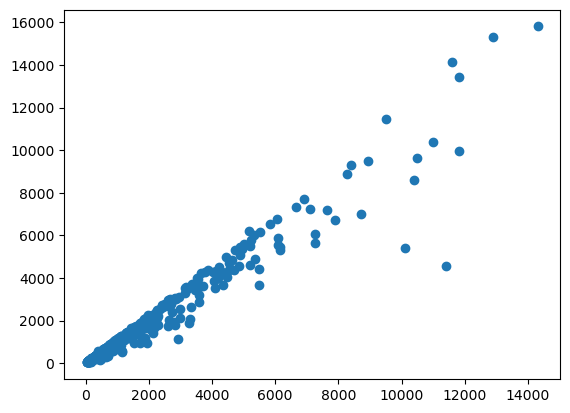

In [50]:
plt.scatter(obs, y_pred)

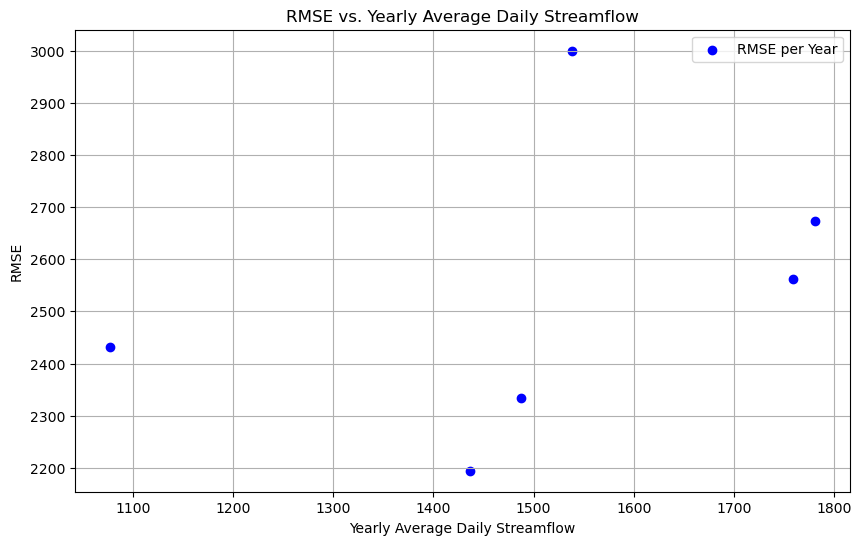

In [52]:
# Prepare yearly average streamflow
yearly_avg_streamflow = df.groupby('year')['runoff'].mean()

# Initialize dictionary to store RMSE for each year
yearly_rmse = {}

# Loop through each year, train on the other years, and test on the current year
for year in range(2016, 2022):
    # Split into train and test (current year)
    train_data = df[df['year'] == year]
    test_data = df[df['year'] != year]
    X_train_custom = train_data[['rainfall', 'runoff_shifted']]
    y_train_custom = train_data['runoff']
    X_test_custom = test_data[['rainfall', 'runoff_shifted']]
    y_test_custom = test_data['runoff']
    # Train the MLP model
    model_custom = MLPRegressor(hidden_layer_sizes=(10, ), random_state =42)
    model_custom.fit(X_train_custom, y_train_custom)
    
    # Predict on the test data and calculate RMSE
    y_pred_custom = model_custom.predict(X_test_custom)
    rmse_custom = np.sqrt(mean_squared_error(y_test_custom, y_pred_custom))
    
    # Store the RMSE for the current year
    yearly_rmse[year] = rmse_custom

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

years = sorted(yearly_rmse.keys())
rmse_values = [yearly_rmse[year] for year in years]
avg_streamflow_values = [yearly_avg_streamflow[year] for year in years]

plt.figure(figsize=(10, 6))
plt.scatter(avg_streamflow_values, rmse_values, color='blue', label='RMSE per Year')

# Add labels and title
plt.xlabel('Yearly Average Daily Streamflow')
plt.ylabel('RMSE')
plt.title('RMSE vs. Yearly Average Daily Streamflow')

# Optional: Add grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.show()